### MScFE 690 Capstone -- Final Submission

### 1. Imports

In [19]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
from fbm import FBM
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
def filter_ransac_warning(message, category, filename, lineno, file=None, line=None):
    return "RANSAC did not reach consensus" not in str(message)
warnings.filterwarnings("ignore", message=".*RANSAC did not reach consensus.*", category=RuntimeWarning)

The MMAR or Multifractal Model of Asset Returns utilizes a compound process denoted as \(X(t)\). This is presented mathematically as:

$$ X(t) = B_H(\theta(t)) $$

Here are the components of the equation:

- \(X(t)\) is our compound process. This signifies the cumulative effect of multiple time scales.
- \(B_H(t)\) is what we call a fractional Brownian motion. This is a variation of a Gaussian process and a generalization of the standard Brownian motion. The Hurst exponent, denoted by \(H\) (with \(0 < H < 1\)), characterizes this motion. A Hurst exponent of \(0.5\) turns \(B_H(t)\) into a standard Brownian motion, while a Hurst exponent less than \(0.5\) indicates negative correlation in the process increments, and a Hurst exponent greater than \(0.5\) suggests positive correlation.
- Lastly, \(\theta(t)\) corresponds to the cumulative distribution function of a specific multifractal cascade measure. This is crucial as it dictates the changing "pace" of the fractional Brownian motion. The precise form of \(\theta(t)\) is contingent on the multifractal cascade measure in use, which itself depends on the distinct properties of the financial time series under study.

### 2. A Look a Fractal Brownian Motion

#### 2.1 Simple FBM Simulation using Nolds

Fractional Brownian Motion can be described as a "walk" where the next step might be influenced by previous steps. This could be for example in the form of momentum or reversion. This introduction of "memory" via the hurst exponent aims to model this well-known memory feature of financial markets. FBM is compontent of the MMAR that will be described in the following sections.

In [2]:
fbm = nolds.fbm(100, H=0.75)

In [3]:
fbm = pd.Series(fbm)

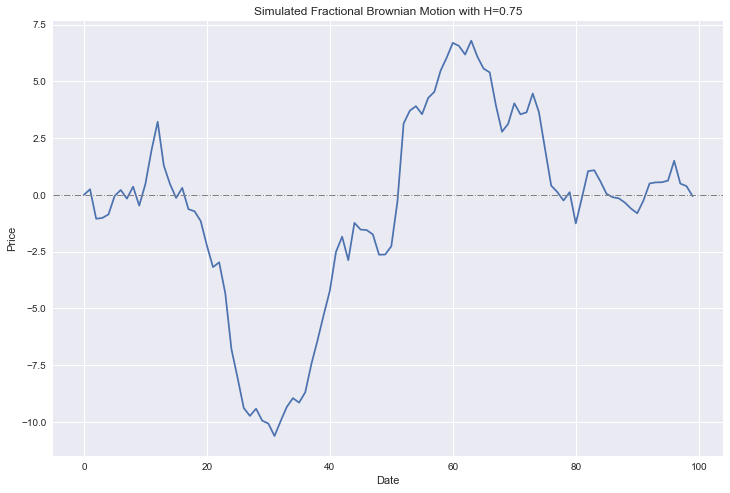

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(fbm)
plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with H=0.75')
# plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#### 2.2 Importing Oil Prices

In [80]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-07-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [81]:
prices = data['Adj Close']

In [82]:
prices.describe()

C:\Users\lucas\anaconda3\envs\main_clone_test_old_pandas\lib\site-packages\pandas\core\nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


count    5756.000000
mean       63.867417
std        25.581803
min       -37.630001
25%        44.544999
50%        61.555000
75%        83.352499
max       145.289993
Name: Adj Close, dtype: float64

#### 2.3 The Hurst Exponent: Calculating Oil's Hurst Exponent

The Hurst exponent \(H\) is a statistical measure used to classify time series data. It can help in determining the nature of a given time series:

- \(H < 0.5\): The time series has a tendency to revert to a mean (negative autocorrelation).
- \(H = 0.5\): The time series follows a random walk (Brownian motion).
- \(H > 0.5\): The time series shows a persistent behavior (positive autocorrelation).

However, different lenghts of timeseries should generate different values of Hurst Exponent. This is due to the fact that the same underlying process (i.e the positive or negative autocorrelation present in the timeseries) can appear differently under different sampling dizes or resolutions. One solution is the one proposed below, where the price data is divided into segments and several calculations of H generating a distribution. 

In [83]:
def segment_data(data, num_segments):
    """
    Splits the data into multiple segments.
    """
    len_segment = len(data) // num_segments
    return [data[i:i+len_segment] for i in range(0, len(data), len_segment) if len(data[i:i+len_segment]) == len_segment]

def calculate_hurst_for_segments(data, num_segments):
    """
    Calculate the Hurst exponent for the segment
    """
    segments = segment_data(data, num_segments)
    hurst_values = [nolds.hurst_rs(seg) for seg in segments]
    return hurst_values

num_segments = 625
hurst_values = calculate_hurst_for_segments(prices, num_segments)

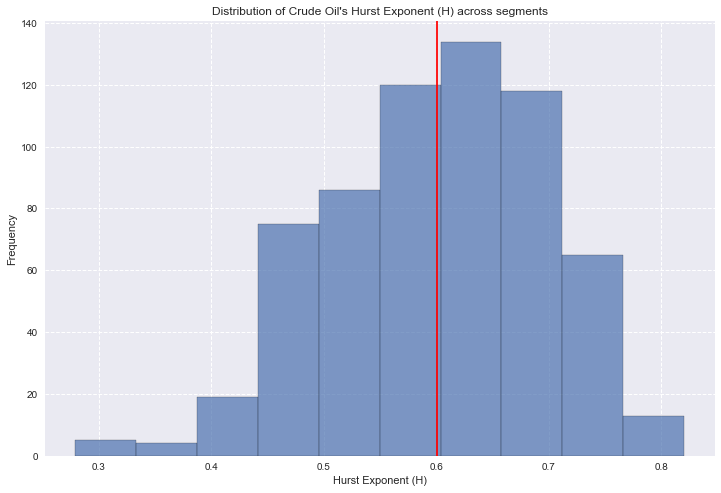

In [84]:
plt.figure(figsize=(12, 8))
plt.hist(hurst_values, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Crude Oil's Hurst Exponent (H) across segments")
plt.xlabel("Hurst Exponent (H)")
plt.ylabel("Frequency")
plt.axvline(np.mean(hurst_values), color='red')
plt.grid(True, which="both", ls="--")
plt.show()

In [87]:
np.mean(hurst_values)

0.6009331915583324

In [88]:
h_oil = np.mean(hurst_values)

Crude Oil's Hurst Exponenet is seen centered around 0.60, i.e small persistence autocorrelation.

#### 2.4 Simulating A FBM with Oil's H

In [89]:
fbm_oil = nolds.fbm(100, H=np.mean(hurst_values))

In [90]:
fbm_oil = pd.Series(fbm_oil)

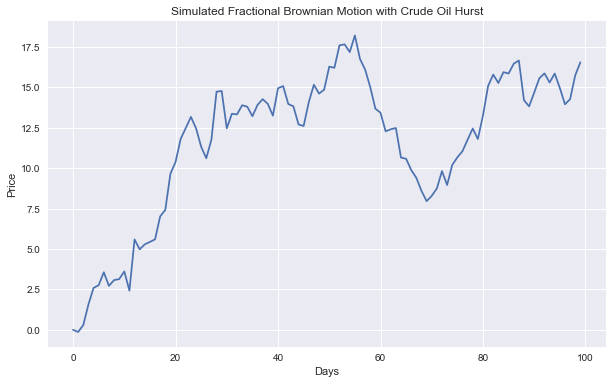

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(fbm_oil)
#plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with Crude Oil Hurst')
# plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

We can see from the above simulation that for any realistic simulation of prices using a FBM, we would need to include a limitation for prices going negative (even though oil prices did go negative in the past!).

To examplify the process of pricing an option using Monte Carlo simulation from a given stochastic model, we will attempt to price an European call option under the assumption that the price of the asset follows a fractional Brownian Motion process (fbm). We will later use the same methodology to calculate the payoff and discounted value for the MMAR simulations:

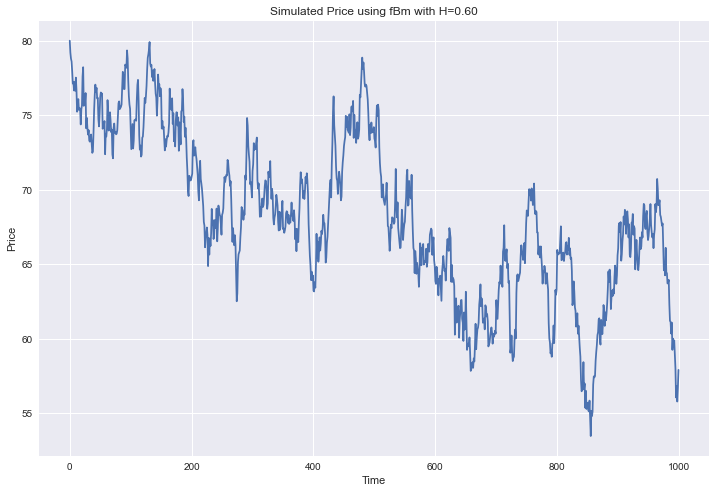

In [93]:
def generate_fbm_path(n, hurst, dt=1, s0=1):
    """Generate a fractional Brownian motion path with n steps and a given Hurst exponent."""
    # Generate Fractional Gaussian Noise using numpy's random.randn
    dW = np.random.randn(n)
    
    # Generate the fBm increments (scales with time as per Hurst exponent)
    increments = dW * (dt**(hurst))
    
    # Construct the fBm path
    fbm_path = np.cumsum(increments)
    
    # Shift the path to start at s0
    fbm_path = fbm_path - fbm_path[0] + s0
    
    return fbm_path

n = 1000  # number of steps
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
prices = generate_fbm_path(n, hurst_mean, s0=80)

# Imposing floor to ensure prices don't go below 0
prices = np.where(prices > 0, prices, 0)

# Plot the simulated prices
plt.figure(figsize=(12, 8))
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Simulated Price using fBm with H={hurst_mean:.2f}')
plt.grid(True)
plt.show()

#### 2.5 Pricing Oil Options with FBM and Monte Carlo

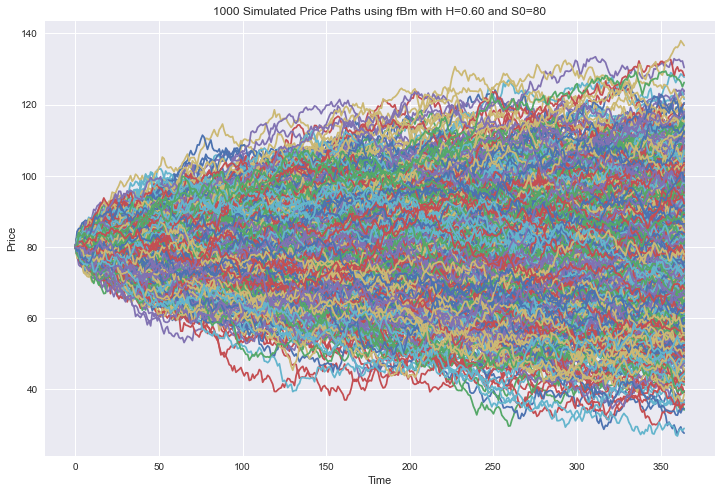

In [94]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, s0=1):
    """Generate multiple fBm paths and plot them."""
    # Create a new plot
    plt.figure(figsize=(12, 8))
    
    # For each path
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, s0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        plt.plot(prices)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{num_paths} Simulated Price Paths using fBm with H={hurst:.2f} and s0={s0}')
    plt.grid(True)
    plt.show()

num_paths = 1000 
n = 365  # Number of steps per path
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
s0 = 80  # Starting price
generate_multiple_paths(num_paths, n, hurst_mean, s0=s0)

In [95]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, S0=1):
    """Generate multiple fBm paths."""
    paths = []
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, S0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        paths.append(prices)
    return paths

def monte_carlo_option_price(num_paths, n, hurst, dt=1, S0=1, r=0.05, T=1, option_type="call", K=None):
    """Compute European option price using Monte Carlo simulation."""
    if K is None:
        K = S0  # If no strike is provided, assume ATM
    
    total_payoff = 0
    
    # Generate multiple price paths
    paths = generate_multiple_paths(num_paths, n, hurst, dt, S0)
    
    # Calculate total payoff from all paths
    for prices in paths:
        ST = prices[-1]  # Price at expiration
        
        # Payoff calculation
        if option_type == "call":
            payoff = max(ST - K, 0)  # Payoff of European call option
        elif option_type == "put":
            payoff = max(K - ST, 0)  # Payoff of European put option
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        
        total_payoff += payoff
    
    # Average payoff
    average_payoff = total_payoff / num_paths
    
    # Discount the average payoff to get option price
    option_price = average_payoff * np.exp(-r * T)
    
    return option_price

# Usage example
num_paths = 1000
n = 252  # Assuming daily steps for a year
hurst_mean = np.mean(hurst_values)
S0 = 80
r = 0.05
T = 1
K = 80  # Strike price

call_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="call", K=K)
put_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="put", K=K)

print(f"European Call Option Price (Strike {K}): ${call_price:.2f}")
print(f"European Put Option Price (Strike {K}): ${put_price:.2f}")

European Call Option Price (Strike 80): $5.97
European Put Option Price (Strike 80): $6.25


We can see from the implied option prices in the market current (picture attached) that the 1year ATM call option price for WTI is currently at $8.8;
This model is underpricing the option relatively to the market.

### 3. The Multifractal Model of Asset Returns

#### 3.1 The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} \xi_i $$

Here, each \( \xi_i \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( \xi_i \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( \tau \) is the time lag, and \( H \) is the Hurst exponent.

Put simply, the multiplicative cascade is a process where at each stage of the cascade (subdivision or step), a given quantity is multiplied by a factor (lower than 1) to produce smaller quantities. The process is an iterative one, creating a hierarchy or cascade of multiplications. In the context of fractals, the Multiplicative Cascade helps to produce a measure that shows multifractal properties. This is because different parts of the data will have different scaling behaviors in result of the cascade multiplication which creates a complex and multifractal structure. 

Below we will explore a few options for generating multifractal processes with the multiplicative cascade methodology. 

#### 3.2 Simplified Model with Multiplicative Cascade

In the section below, we attempt to use a simplified MMAR model implementing a multifractal measure with multiplicative cascade.

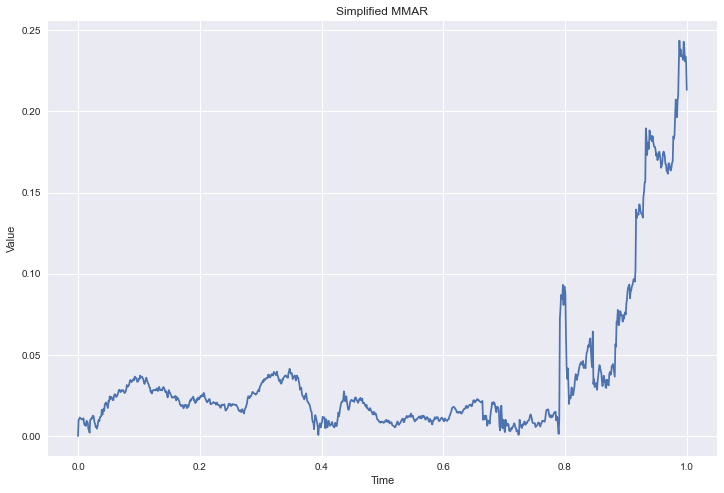

In [130]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
        
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
    
    return MMAR


# Set the parameters
hurst = 0.60
num_intervals = 252
mu = 0.1
sigma = 0.40
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

With this model, we are able to produce price charts that resemble real asset asset prices, but that are not realistic enough just yet. We make the following simplifications relatively to the MMAR:  
  
1 - Mandelbrot's MMAR employs a much more intricate procedure for the multifractal measure construction, using binomial cascades to generate a range of measures.   
2 - In Mandelbrot's MMAR, volatility is governed by trading time which evolves in a multifractal fashion while this model only applies the cascade to regular calendar time.  
3 - MMAR involves several more parameters to capture various features of timeseries behavior.  
4 - MMAR does not inherently prevent prices from going negative (like we are doing here).  

#### 3.3 An Attempt at a More Sophisticated Multifractal Generator

Now, for a slightly more realistic representation, we'll add the parameters alpha and beta to the multifractal measure, making sure that the interval weights are influenced by H, making the model more sensitive to long-term memory. We'll also implement time-varying volatility, as a function of trading time, similar to what is proposed by the MMAR. 

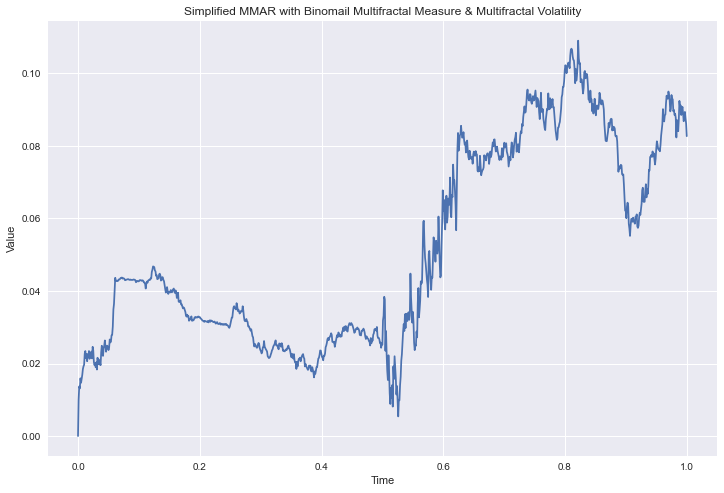

In [134]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
        
    return MMAR

# Set the parameters
hurst = 0.75
num_intervals = 10
mu = 0.1
sigma = 0.2
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR with Binomail Multifractal Measure & Multifractal Volatility')
plt.show()

After producing some simplified versions of the model to illustrate its workings and main components, we will use Crude Oil's data to calculate the necessary parameters for a yet more realistic version of the MMAR proposed by Mandelbrot, using the parameters found in the real data. 

#### 3.4 Calculate the necessary Fractal Parameters for the Simulations

We will be loading a longer price series of WTI prices as the yahoo finance API had limited datapoints. 

The steps to calculate the fractal parameters are as follows:

1. Get a highly composite number of data points (7560 in this case)
2. Generate $\Delta t$ (or $dt$) which are the time increments
3. Generate the statistical moments $q$ that will be used for the partition function.
4. Calculate the partition function for different values of $dt$ and $q$
5. Calculate the scaling function $\tau_q$ (the regressions of the partition functions). Use lower moments. 
6. Estimate the precise value of $H$
7. Calculate $\alpha_0$
8. Calculate $\lambda$ and $\sigma^2$

#### Obtain and Format Data

In [57]:
prices_data = prices.copy()

In [58]:
close_return = np.log(prices_data/prices_data.shift())
close_return = close_return.dropna()

C:\Users\EricaKo\anaconda3\envs\backtesting_areix\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
prices_data_train = prices.iloc[:-30]
prices_data_test = prices.iloc[-30:]

#### Raw Statistical Moments

In [76]:
# Define the sequence ranges
# Select the values of q
# The q here

q = np.linspace(0.01, 3, 120) # up to a value with a quadratic shape
q

array([0.01      , 0.03512605, 0.0602521 , 0.08537815, 0.1105042 ,
       0.13563025, 0.1607563 , 0.18588235, 0.2110084 , 0.23613445,
       0.2612605 , 0.28638655, 0.31151261, 0.33663866, 0.36176471,
       0.38689076, 0.41201681, 0.43714286, 0.46226891, 0.48739496,
       0.51252101, 0.53764706, 0.56277311, 0.58789916, 0.61302521,
       0.63815126, 0.66327731, 0.68840336, 0.71352941, 0.73865546,
       0.76378151, 0.78890756, 0.81403361, 0.83915966, 0.86428571,
       0.88941176, 0.91453782, 0.93966387, 0.96478992, 0.98991597,
       1.01504202, 1.04016807, 1.06529412, 1.09042017, 1.11554622,
       1.14067227, 1.16579832, 1.19092437, 1.21605042, 1.24117647,
       1.26630252, 1.29142857, 1.31655462, 1.34168067, 1.36680672,
       1.39193277, 1.41705882, 1.44218487, 1.46731092, 1.49243697,
       1.51756303, 1.54268908, 1.56781513, 1.59294118, 1.61806723,
       1.64319328, 1.66831933, 1.69344538, 1.71857143, 1.74369748,
       1.76882353, 1.79394958, 1.81907563, 1.84420168, 1.86932

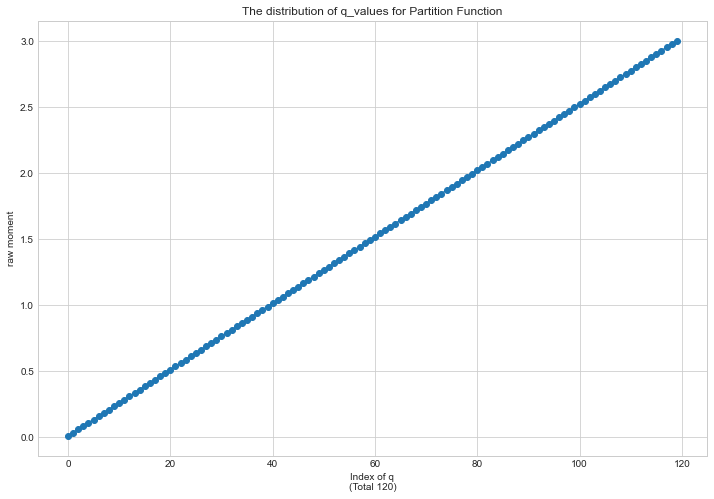

In [77]:
# Plotting q_values
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title("The distribution of q_values for Partition Function")
plt.xlabel(f"Index of q\n(Total {len(q)})")
plt.ylabel('raw moment')
plt.plot(q, marker='o')
plt.show()

#### Partition Function

In summary, the Chhabra-Jensen method uses the partition function to characterize scaling behavior and then Legendre transforms this to derive the multifractal spectrum.

In [78]:
min_window = 10
max_window = len(prices_data_train)
print('length of the training prices data: ', len(prices_data_train))

window_sizes = list(map(
        lambda x: int(10**x), # NOTE: in the paper, it said the window should be 2**n instead of 10**n
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
window_sizes

length of the training prices data:  5706


[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 5623]

In [79]:
def partition_function(delta, x_t, q):
    '''
    @params
    delta array: time interval range
    x_t array: the time series
    q float: the power q
    '''
    # Initialize a 2D array sigma to store the partition function values.
    # row for different delta
    Fq = [[0 for x in range(len(delta))] for y in range(len(q))]
    
    # Loop through each exponent q[k] and time lag delta[j].
    # For each q and delta, compute the partition function by:
    # i) Iterating through the time series in chunks of size delta[j]
    # ii) Calculating the absolute difference between each point and the point delta[j] steps ahead
    # iii) Summing the q[k] power of these differences
    for k in range (0, len(q)):
        if k%30==0: # dividable by 30
            print("calculating q=" + str(k) + ' out of ' + str(len(q)-1))
            
        for j in range (0,len(delta)):
            
            for i in range (0,len(x_t)-1):
                if i < int((len(x_t)-1)/delta[j]):
                    Fq[k][j]=Fq[k][j] + abs(x_t[i*delta[j]+delta[j]]-x_t[i*delta[j]])**q[k]

    Fq=pd.DataFrame(Fq)

    for i in range(0,len(q)):
        Fq.rename(index={Fq.index[i]:q[i]}, inplace=True)
    for i in range(len(delta)-1,-1,-1):
        Fq.rename(columns={Fq.columns[i]:delta[i]}, inplace=True)

    print("Finished. Return Fq...")
    return Fq

In [80]:
Fq = partition_function(window_sizes, prices_data_train, q)

Calculating the partition function...
This step will take quite a while... so strap yourself in...

calculating q=0 out of 119
calculating q=30 out of 119
calculating q=60 out of 119
calculating q=90 out of 119
Finished. Return Fq...


In [81]:
Fq

,10,17,31,56,100,177,316,562,1000,1778,3162,5623
0.010000,574.199069,338.557241,186.454700,102.567594,57.987579,3.273824e+01,18.457816,10.262990,5.123352,3.039287,1.042018,1.039347
0.035126,585.201444,347.836527,192.874896,106.683613,60.590000,3.470036e+01,19.670754,10.962584,5.457136,3.147290,1.155550,1.145178
0.060252,596.864841,357.620671,199.670304,111.065446,63.374061,3.682555e+01,20.979208,11.721509,5.827548,3.269415,1.281453,1.261786
0.085378,609.209099,367.931558,206.859499,115.729436,66.351217,3.912684e+01,22.391131,12.544898,6.238002,3.406792,1.421072,1.390267
0.110504,622.255800,378.792571,214.462398,120.693262,69.533949,4.161845e+01,23.915175,13.438341,6.692271,3.560675,1.575904,1.531831
...,...,...,...,...,...,...,...,...,...,...,...,...
2.899496,105337.345460,143275.351159,139260.327793,309398.730867,481758.710102,8.467618e+05,315394.045614,184473.040788,348991.279471,80454.231300,152384.069927,72395.088285
2.924622,112471.785498,154025.471171,149797.481147,337603.674407,533222.020132,9.413848e+05,346641.758198,202301.403288,387460.482220,88721.235774,168986.951300,79766.713399
2.949748,120125.507836,165624.561400,161160.586588,368435.869351,590293.846745,1.046763e+06,381009.212663,221866.390271,430184.897319,97838.058881,187398.785997,87888.953757
2.974874,128338.404539,178142.204712,173416.162963,402144.119888,653594.227516,1.164135e+06,418809.739830,243338.352431,477636.514939,107892.072756,207816.667044,96838.240706


In [82]:
# Power-law regression on log Fq(n) vs log delta to get scaling exponent τ(q)
# If the signal has scaling properties, Fq(n) will follow a power law:
# Fq(n) ~ n^τ(q)
tau_q_list = []
for i,row in Fq.iterrows():
    Fq_matrix = np.vstack([np.log10(row.values), np.ones(len(row))]).T
    tau_q, c = np.linalg.lstsq(Fq_matrix, np.log10(window_sizes), rcond=-1)[0]
    tau_q_list.append(tau_q)

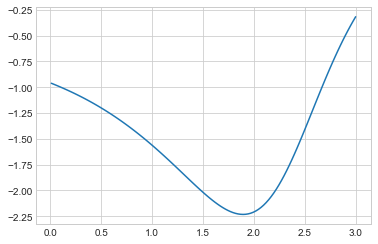

In [83]:
# plot τ(q) with q
# Monofractal signals show a linear τ(q) curve. The slope gives the single Hurst exponent H.
# Multifractal τ(q) curves are nonlinear. The curvature reveals richer structure.
plt.plot(Fq.index, tau_q_list)

#### calculate Hurst Exponent H

In [84]:
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(prices_data_train, kind='price', simplified=False)
H

0.5611684682811867

#### Estimate the Multifractal Spectrum f(a)
- Legendre transform τ(q) to get f(α) Multifractal spectrum:
- By scanning over different values of q, we can trace out the multifractal spectrum f(α).

In [85]:
def estimate_multifractal_spectrum(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)

    F_A = [0 for x in range(len(q)-10)]
    p = [0 for x in range(len(q)-10)]

    a = TAU_Q_ESTIMATED[0]
    b = TAU_Q_ESTIMATED[1]
    c = TAU_Q_ESTIMATED[2]

    for i in range(0, len(q)-10):
        p[i] = 2*a*Q[i]+b
        F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)

    F_A = pd.DataFrame(F_A)
    F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
    F_A['p'] = p

    print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
    # TAU_Q_ESTIMATED are the coefficients (a,b,c) from fitting the quadratic model to τ(q).
    print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
    
    # the three estimated parameters for f(a) are derived from the Legendre transform relations:
    # i) 1/(4*a) is the width of the f(α) spectrum
    width_of_spectrum = 1/(4*a)
    # ii) (-2b)/(4a) is the position of the peak α0 == most probable Hölder exponent
    holder_exponent = (-2*b)/(4*a)
    # iii) (-4ac+b^2)/(4*a) is related to asymmetry in f(α)
    asymmetry_of_spectrum = (-4*a*c+b**2)/(4*a)
    # they give key properties of f(α) spectrum
    print("\nThus, the estimated parameters for f(a) are: \n width_of_spectrum: " + str(width_of_spectrum) + ", \n holder_exponent: "  + str(holder_exponent) + ", \n asymmetry_of_spectrum: "+ str(asymmetry_of_spectrum))

    return F_A, (width_of_spectrum, holder_exponent, asymmetry_of_spectrum)

In [86]:
F_A, parameters_of_spectrum = estimate_multifractal_spectrum(tau_q_list, q, 0, len(q)-1)

Using the range of q's from 0.01 to 3.0:
The estimated parameters for tau(q) are: 
[ 0.66908211 -2.04440568 -0.46286365]

Thus, the estimated parameters for f(a) are: 
 width_of_spectrum: 0.37364621681430393, 
 holder_exponent: 1.5277688928626179, 
 asymmetry_of_spectrum: 2.0245533481012044


#### Find the most probable Hölder exponent.

- The width of f(α) indicates degree of multifractality. α_min and α_max give range of Hölder exponents.

- The α at max f(α) gives the most probable Hölder exponent α0

- α0 = a for max[f(α)]

- Sibirtsev concludes, “The interpretation for α0 is this: if the data is multifractal —
meaning that it can have different Hölder exponents at different timepoints — then
α0 is the most commonly occurring, most “dominant” Hölder exponent in the price
data.”

The Hölder exponent indicates the local regularity or "smoothness" of a signal at a given point. It quantifies the scaling behavior and singularity strength. The Hölder exponent α measures how fast the signal is oscillating or changing as you zoom in.  

Larger exponent just implies higher order differentiability and smoothness in the signal's dynamics. The magnitude quantifies exactly how stable and noise-free it looks at finer scales.

In [87]:
# from the result above the
a0 = parameters_of_spectrum[1]
a0

1.5277688928626179

#### Estimate the log-normal distribution parameters

In [88]:
# λ = α0 / H
simulated_lambda = a0 / H
print(simulated_lambda)

# σ2 = 2(λ — 1) / ln[b]
simulated_sigma = 2*(simulated_lambda - 1) / np.log(2)
print(simulated_sigma)

2.72247814910565
4.970021367508643


#### Determine the number of data points to simulate

Here we are considering in using the binomial cascade, meaning that each interval is split into two each time (meaning b=2)

The simulation takes b*k data points. Therefore it is best to select b and k close to the desired number of data points. For example, if we want to simulate 7560 data points. When b = 2 and k = 13 he gets 8192 simulated data points to cover our need

In [89]:
# find the k when b == 2
display(len(prices_data_test))
K = math.ceil(np.log2(len(prices_data_test))) # k value
display(K)
display(2**K)

30

5

32

#### Generate a log-normal multiplicative cascade

In summary, the code implements the theoretical lognormal cascade by recursively splitting, weighting, and branching the value v at each step.

At each step, it splits the value v into two parts, multiplies each by a random lognormal weight, and recursively cascades those parts. This matches the theoretical description of a multiplicative lognormal cascade:

- Splitting into two parts (b=2)
- Multiplying by random lognormal weights
- Cascading recursively in a branching way

In [90]:
def lognormal_cascade(k, v,ln_lambda, ln_theta):

    k = k - 1
    
    # FIXME: 
    # i) limit for the weight to avoid exponential weighting
    m0 = np.random.lognormal(ln_lambda,ln_theta)
    m1 = np.random.lognormal(ln_lambda,ln_theta)
    M = [m0, m1]

    if (k >= 0):
        d=[0 for x in range(0,2)]
        for i in range(0,2):
            d[i] = lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)

        v = d

    return v

#### Find the trading time function θ(t)

In [91]:
new_cascade = list(np.array(lognormal_cascade(k=K, v=1, ln_lambda = simulated_lambda, ln_theta = simulated_sigma)).flat)
tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)

The key is using the lognormal cascade to create a clustered, heavy-tailed distribution for θ(t). θ(t) maps the physical time t into a trading time scale

#### Simulate a Fractional Brownian Motion

In [99]:
# Sibirtsev describes, “I had to manually adjust the
# fBm “length” for each [market] until the median standard deviation of returns was
# approximately the same as that of the real data
# find the suitable magnitude_parameter by adjust the
# fBm “length” for each [market] until the median standard deviation of returns was
# approximately the same as that of the real data

magnitude_parameter = 2980
eps = 0.01
steps = 0.01
diff = np.inf
number_of_path = 20 # FIXME: if more simulated path is needed multiprocessing is needed
real_std = np.std(prices_data_train)

while abs(diff) > eps:
    std_list = []
    for nb in tqdm(range(number_of_path)):
        new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
        new_fbm_simulation = new_fbm_class.fbm()
        std_list.append(np.std(new_fbm_simulation))
    diff = real_std - np.median(std_list)
    #print('Diff: ', diff)
    if abs(diff) > eps:
        magnitude_parameter += diff * steps
    #    print('new magnitude_parameter:', magnitude_parameter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.76it/s]


Diff:  -1.0300460006259797
new magnitude_parameter: 2999.9896995399936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.67it/s]


Diff:  -1.0652938050539156
new magnitude_parameter: 2999.979046601943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.18it/s]


Diff:  -1.002909663219274
new magnitude_parameter: 2999.969017505311


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 114.24it/s]


Diff:  -4.829248520613014
new magnitude_parameter: 2999.920725020105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.09it/s]


Diff:  -5.401789474272309
new magnitude_parameter: 2999.866707125362


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.26it/s]


Diff:  -1.5380311798148725
new magnitude_parameter: 2999.851326813564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 112.74it/s]


Diff:  -6.656866796429256
new magnitude_parameter: 2999.7847581455994


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.88it/s]


Diff:  -11.444951806049325
new magnitude_parameter: 2999.670308627539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.56it/s]


Diff:  -2.3846116239055277
new magnitude_parameter: 2999.6464625113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.54it/s]


Diff:  -3.5735396741129968
new magnitude_parameter: 2999.610727114559


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 113.74it/s]


Diff:  0.55483879420348
new magnitude_parameter: 2999.6162755025007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.81it/s]


Diff:  1.0973456940555657
new magnitude_parameter: 2999.627248959441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.88it/s]


Diff:  -3.451571563815584
new magnitude_parameter: 2999.592733243803


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.99it/s]


Diff:  -2.2525063322324144
new magnitude_parameter: 2999.5702081804807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.82it/s]


Diff:  -6.109834560736665
new magnitude_parameter: 2999.5091098348735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.02it/s]


Diff:  -9.529283203388708
new magnitude_parameter: 2999.4138170028396


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.12it/s]


Diff:  -3.22634622020653
new magnitude_parameter: 2999.3815535406375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.98it/s]


Diff:  0.3473611800806893
new magnitude_parameter: 2999.3850271524384


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.52it/s]


Diff:  -5.814045301613554
new magnitude_parameter: 2999.326886699422


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.20it/s]


Diff:  -1.1982030589012957
new magnitude_parameter: 2999.314904668833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 111.99it/s]


Diff:  -3.187261800372319
new magnitude_parameter: 2999.283032050829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.56it/s]


Diff:  -6.125632634791202
new magnitude_parameter: 2999.221775724481


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.81it/s]


Diff:  -2.499139779538858
new magnitude_parameter: 2999.1967843266857


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.50it/s]


Diff:  -4.9696829507575515
new magnitude_parameter: 2999.1470874971783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.03it/s]


Diff:  -1.8376334003605947
new magnitude_parameter: 2999.1287111631746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.01it/s]


Diff:  -8.504521887473707
new magnitude_parameter: 2999.0436659443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.96it/s]


Diff:  -5.019158188266921
new magnitude_parameter: 2998.993474362417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 118.47it/s]


Diff:  -9.121454442934962
new magnitude_parameter: 2998.9022598179877


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.08it/s]


Diff:  -5.364759692328601
new magnitude_parameter: 2998.8486122210643


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.81it/s]


Diff:  -0.6129346317445723
new magnitude_parameter: 2998.842482874747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.83it/s]


Diff:  -5.74760259402364
new magnitude_parameter: 2998.785006848807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.05it/s]


Diff:  -2.388745744532933
new magnitude_parameter: 2998.7611193913617


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.45it/s]


Diff:  -8.756504399460475
new magnitude_parameter: 2998.673554347367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.99it/s]


Diff:  -5.211038604292938
new magnitude_parameter: 2998.621443961324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.55it/s]


Diff:  -5.580950021616992
new magnitude_parameter: 2998.565634461108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.02it/s]


Diff:  -8.783032081844077
new magnitude_parameter: 2998.4778041402897


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 108.72it/s]


Diff:  -6.546077844544257
new magnitude_parameter: 2998.4123433618443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.28it/s]


Diff:  -0.5254156255959828
new magnitude_parameter: 2998.4070892055884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.70it/s]


Diff:  -3.1032281227240617
new magnitude_parameter: 2998.376056924361


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.66it/s]


Diff:  0.873102608188276
new magnitude_parameter: 2998.384787950443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.74it/s]


Diff:  1.3848023158181917
new magnitude_parameter: 2998.398635973601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.85it/s]


Diff:  0.16552019447652455
new magnitude_parameter: 2998.4002911755456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.31it/s]


Diff:  -7.32693654586312
new magnitude_parameter: 2998.327021810087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.23it/s]


Diff:  -4.889358217060632
new magnitude_parameter: 2998.2781282279166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.47it/s]


Diff:  -3.899567451158056
new magnitude_parameter: 2998.239132553405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.49it/s]


Diff:  -10.40213881052788
new magnitude_parameter: 2998.1351111653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.12it/s]


Diff:  1.1121380226728448
new magnitude_parameter: 2998.1462325455263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 153.64it/s]


Diff:  0.7902125454111513
new magnitude_parameter: 2998.1541346709805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.48it/s]


Diff:  -1.7239031252891195
new magnitude_parameter: 2998.1368956397278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.18it/s]


Diff:  -10.604383515557764
new magnitude_parameter: 2998.030851804572


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.31it/s]


Diff:  -10.628360655099392
new magnitude_parameter: 2997.924568198021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.07it/s]


Diff:  -1.2516769501275604
new magnitude_parameter: 2997.9120514285196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.32it/s]


Diff:  -4.448761098043683
new magnitude_parameter: 2997.867563817539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.68it/s]


Diff:  -6.956135451143233
new magnitude_parameter: 2997.798002463028


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.78it/s]


Diff:  -4.259251211029202
new magnitude_parameter: 2997.7554099509175


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.16it/s]


Diff:  -3.655755540815491
new magnitude_parameter: 2997.718852395509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.42it/s]


Diff:  -3.75276777868536
new magnitude_parameter: 2997.6813247177224


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.83it/s]


Diff:  -7.0231589330766795
new magnitude_parameter: 2997.6110931283915


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.27it/s]


Diff:  3.4641885496645557
new magnitude_parameter: 2997.645735013888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.78it/s]


Diff:  0.6793535452765873
new magnitude_parameter: 2997.652528549341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 113.87it/s]


Diff:  -3.0999102490628445
new magnitude_parameter: 2997.62152944685


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.93it/s]


Diff:  0.9427957246818721
new magnitude_parameter: 2997.630957404097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.02it/s]


Diff:  -4.480381888368349
new magnitude_parameter: 2997.586153585213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.77it/s]


Diff:  -10.139070122030084
new magnitude_parameter: 2997.484762883993


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 158.07it/s]


Diff:  -3.504570220428299
new magnitude_parameter: 2997.449717181789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.66it/s]


Diff:  -1.0262233269801904
new magnitude_parameter: 2997.439454948519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.04it/s]


Diff:  -0.3304263381752577
new magnitude_parameter: 2997.4361506851374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.92it/s]


Diff:  -2.1209442848072086
new magnitude_parameter: 2997.4149412422894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.81it/s]


Diff:  -8.550767574014415
new magnitude_parameter: 2997.329433566549


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.82it/s]


Diff:  -3.1584717317142044
new magnitude_parameter: 2997.297848849232


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.13it/s]


Diff:  -2.172808427167709
new magnitude_parameter: 2997.2761207649605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.33it/s]


Diff:  1.0774883600088039
new magnitude_parameter: 2997.2868956485604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.71it/s]


Diff:  -6.581852094466193
new magnitude_parameter: 2997.221077127616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 107.70it/s]


Diff:  1.6926831139387168
new magnitude_parameter: 2997.238003958755


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.38it/s]


Diff:  -0.5195717196163088
new magnitude_parameter: 2997.232808241559


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.46it/s]


Diff:  -5.212901543069087
new magnitude_parameter: 2997.180679226128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.95it/s]


Diff:  -2.0292348812746965
new magnitude_parameter: 2997.1603868773154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 138.70it/s]


Diff:  -7.238302271322318
new magnitude_parameter: 2997.088003854602


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.71it/s]


Diff:  -6.718407884809338
new magnitude_parameter: 2997.020819775754


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.24it/s]


Diff:  -5.6036825269109585
new magnitude_parameter: 2996.9647829504847


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 149.23it/s]


Diff:  -3.7408480794651773
new magnitude_parameter: 2996.92737446969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.51it/s]


Diff:  -2.180999279613367
new magnitude_parameter: 2996.905564476894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 151.52it/s]


Diff:  -6.708467288520048
new magnitude_parameter: 2996.838479804009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 148.65it/s]


Diff:  -2.5788149501598987
new magnitude_parameter: 2996.812691654507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.67it/s]


Diff:  -2.530945936354037
new magnitude_parameter: 2996.7873821951434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 149.19it/s]


Diff:  -1.2967078325274173
new magnitude_parameter: 2996.774415116818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 152.40it/s]


Diff:  -0.9784518502076978
new magnitude_parameter: 2996.764630598316


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.46it/s]


Diff:  -1.4932748669632119
new magnitude_parameter: 2996.7496978496465


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.06it/s]


Diff:  -1.0292767861493601
new magnitude_parameter: 2996.739405081785


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.47it/s]


Diff:  -4.596778376405766
new magnitude_parameter: 2996.6934372980213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.01it/s]


Diff:  -5.040717518469648
new magnitude_parameter: 2996.6430301228365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.93it/s]


Diff:  -12.749299412610895
new magnitude_parameter: 2996.5155371287105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.20it/s]


Diff:  -7.195440742914521
new magnitude_parameter: 2996.4435827212815


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.65it/s]


Diff:  -0.6960258260026784
new magnitude_parameter: 2996.4366224630216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.74it/s]


Diff:  -3.3308927753432442
new magnitude_parameter: 2996.4033135352684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.59it/s]


Diff:  -3.530643565768081
new magnitude_parameter: 2996.3680070996106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.33it/s]


Diff:  -3.158462195925054
new magnitude_parameter: 2996.3364224776515


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.05it/s]


Diff:  -1.9459276083640908
new magnitude_parameter: 2996.316963201568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.72it/s]


Diff:  -8.000947486456653
new magnitude_parameter: 2996.236953726703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.98it/s]


Diff:  -5.358670002601972
new magnitude_parameter: 2996.183367026677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.52it/s]


Diff:  -2.594430172883122
new magnitude_parameter: 2996.157422724948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.23it/s]


Diff:  -0.8197674550475043
new magnitude_parameter: 2996.1492250503975


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.55it/s]


Diff:  0.25211197036998456
new magnitude_parameter: 2996.151746170101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.71it/s]


Diff:  -2.0241589300113567
new magnitude_parameter: 2996.131504580801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.88it/s]


Diff:  -0.8788992138072302
new magnitude_parameter: 2996.122715588663


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.76it/s]


Diff:  -5.87443180165134
new magnitude_parameter: 2996.0639712706466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.72it/s]


Diff:  -3.496860861270747
new magnitude_parameter: 2996.0290026620337


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.32it/s]


Diff:  0.5328954766143319
new magnitude_parameter: 2996.0343316168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.20it/s]


Diff:  -2.3275584522776462
new magnitude_parameter: 2996.0110560322773


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.68it/s]


Diff:  -3.667889715645238
new magnitude_parameter: 2995.974377135121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.34it/s]


Diff:  -8.467934114766926
new magnitude_parameter: 2995.889697793973


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.32it/s]


Diff:  0.5245541396680835
new magnitude_parameter: 2995.8949433353696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.35it/s]


Diff:  -0.3895631045524617
new magnitude_parameter: 2995.891047704324


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.79it/s]


Diff:  -2.778554936976093
new magnitude_parameter: 2995.8632621549546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 161.48it/s]


Diff:  -1.4573680982892085
new magnitude_parameter: 2995.848688473972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.43it/s]


Diff:  -0.911623374777534
new magnitude_parameter: 2995.8395722402242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.01it/s]


Diff:  -1.8980123034601881
new magnitude_parameter: 2995.82059211719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.90it/s]


Diff:  -3.586639537893113
new magnitude_parameter: 2995.784725721811


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.13it/s]


Diff:  -6.12613014758066
new magnitude_parameter: 2995.723464420335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.33it/s]


Diff:  -7.167608258281533
new magnitude_parameter: 2995.6517883377524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.85it/s]


Diff:  -2.156245509216795
new magnitude_parameter: 2995.6302258826604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.24it/s]


Diff:  0.21611037901416807
new magnitude_parameter: 2995.6323869864505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.93it/s]


Diff:  -4.2889693893889955
new magnitude_parameter: 2995.5894972925566


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.60it/s]


Diff:  -2.415835082732343
new magnitude_parameter: 2995.5653389417294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.19it/s]


Diff:  -3.717735318508531
new magnitude_parameter: 2995.528161588544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.76it/s]


Diff:  -6.704552786016393
new magnitude_parameter: 2995.461116060684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.76it/s]


Diff:  -7.651053070618836
new magnitude_parameter: 2995.3846055299778


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.97it/s]


Diff:  -1.8856720032182928
new magnitude_parameter: 2995.3657488099457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.83it/s]


Diff:  -6.924533034799957
new magnitude_parameter: 2995.2965034795975


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.31it/s]


Diff:  3.4712069074603775
new magnitude_parameter: 2995.331215548672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.83it/s]


Diff:  -0.4894872467653393
new magnitude_parameter: 2995.3263206762044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.35it/s]


Diff:  -3.151077235287328
new magnitude_parameter: 2995.2948099038517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.35it/s]


Diff:  -3.9745955252044674
new magnitude_parameter: 2995.2550639486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.87it/s]


Diff:  -3.4179044842083854
new magnitude_parameter: 2995.220884903758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.90it/s]


Diff:  -1.2454369973671007
new magnitude_parameter: 2995.2084305337844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.76it/s]


Diff:  0.8141947819517128
new magnitude_parameter: 2995.216572481604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.06it/s]


Diff:  -1.5281737140620386
new magnitude_parameter: 2995.2012907444637


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.05it/s]


Diff:  -2.384123665981029
new magnitude_parameter: 2995.177449507804


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.77it/s]


Diff:  -7.792273430955646
new magnitude_parameter: 2995.0995267734943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.31it/s]


Diff:  -0.2007049923375952
new magnitude_parameter: 2995.0975197235707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.84it/s]


Diff:  -2.6412431965639023
new magnitude_parameter: 2995.071107291605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.85it/s]


Diff:  -2.4878354046616096
new magnitude_parameter: 2995.0462289375587


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.10it/s]


Diff:  -2.2837327009728696
new magnitude_parameter: 2995.023391610549


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.56it/s]


Diff:  -3.4642668861704635
new magnitude_parameter: 2994.9887489416874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.20it/s]


Diff:  -5.569098820963109
new magnitude_parameter: 2994.9330579534776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.32it/s]


Diff:  0.7062462434587005
new magnitude_parameter: 2994.940120415912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.33it/s]


Diff:  -3.977225904449405
new magnitude_parameter: 2994.9003481568675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.86it/s]


Diff:  -5.051267676398119
new magnitude_parameter: 2994.8498354801036


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.31it/s]


Diff:  1.115516274901978
new magnitude_parameter: 2994.860990642853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.38it/s]


Diff:  -4.455645957846265
new magnitude_parameter: 2994.8164341832744


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.34it/s]


Diff:  -4.715512150780398
new magnitude_parameter: 2994.7692790617666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 149.30it/s]


Diff:  -0.19877211189196942
new magnitude_parameter: 2994.7672913406477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.87it/s]


Diff:  -2.8543894527132316
new magnitude_parameter: 2994.7387474461207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.12it/s]


Diff:  -6.438322076884312
new magnitude_parameter: 2994.674364225352


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 152.13it/s]


Diff:  0.15241545946966895
new magnitude_parameter: 2994.6758883799466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.65it/s]


Diff:  0.966656441669322
new magnitude_parameter: 2994.6855549443635


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.93it/s]


Diff:  -4.0273963530553445
new magnitude_parameter: 2994.645280980833


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.00it/s]


Diff:  0.5296191393381093
new magnitude_parameter: 2994.6505771722263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.11it/s]


Diff:  -2.724015727539026
new magnitude_parameter: 2994.623337014951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.97it/s]


Diff:  -5.120757843233484
new magnitude_parameter: 2994.572129436519


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.90it/s]


Diff:  -10.60674228603056
new magnitude_parameter: 2994.4660620136588


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.54it/s]


Diff:  -4.63638408472703
new magnitude_parameter: 2994.4196981728114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.29it/s]


Diff:  2.489270608991262
new magnitude_parameter: 2994.444590878901


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.97it/s]


Diff:  -0.07628118976702325
new magnitude_parameter: 2994.4438280670033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.36it/s]


Diff:  -2.3079185047870254
new magnitude_parameter: 2994.4207488819557


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.36it/s]


Diff:  -2.30205509518904
new magnitude_parameter: 2994.3977283310037


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.51it/s]


Diff:  -3.7410556726761897
new magnitude_parameter: 2994.360317774277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.60it/s]


Diff:  -3.5783406292324003
new magnitude_parameter: 2994.3245343679846


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.60it/s]


Diff:  -8.621779211346116
new magnitude_parameter: 2994.238316575871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.24it/s]


Diff:  -1.41396498760664
new magnitude_parameter: 2994.224176925995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.88it/s]


Diff:  -0.02624507882722682
new magnitude_parameter: 2994.2239144752066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.06it/s]


Diff:  -2.747273258142087
new magnitude_parameter: 2994.196441742625


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.35it/s]


Diff:  -5.947258332638182
new magnitude_parameter: 2994.136969159299


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.58it/s]


Diff:  -0.04030921101839624
new magnitude_parameter: 2994.136566067189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.82it/s]


Diff:  0.7603821006326967
new magnitude_parameter: 2994.1441698881954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.40it/s]


Diff:  -0.6095769647517599
new magnitude_parameter: 2994.138074118548


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.82it/s]


Diff:  -11.514758251693912
new magnitude_parameter: 2994.0229265360313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.05it/s]


Diff:  -1.2278683718403798
new magnitude_parameter: 2994.010647852313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.93it/s]


Diff:  -4.944461287055997
new magnitude_parameter: 2993.9612032394425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.31it/s]


Diff:  -4.943600855879069
new magnitude_parameter: 2993.911767230884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.59it/s]


Diff:  -8.881605938759407
new magnitude_parameter: 2993.8229511714962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.40it/s]


Diff:  -5.780966835557582
new magnitude_parameter: 2993.7651415031405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.85it/s]


Diff:  -3.687609383812344
new magnitude_parameter: 2993.7282654093024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.97it/s]


Diff:  -1.9867890372302455
new magnitude_parameter: 2993.7083975189303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.72it/s]


Diff:  -4.5698697587553845
new magnitude_parameter: 2993.662698821343


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.46it/s]


Diff:  -4.647248362668211
new magnitude_parameter: 2993.6162263377164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.20it/s]


Diff:  -0.7782781267501946
new magnitude_parameter: 2993.608443556449


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.03it/s]


Diff:  -4.552440030427537
new magnitude_parameter: 2993.5629191561447


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.99it/s]


Diff:  -0.8036954917831167
new magnitude_parameter: 2993.554882201227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.81it/s]


Diff:  -0.626699477438553
new magnitude_parameter: 2993.5486152064527


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.45it/s]


Diff:  3.530829218184408
new magnitude_parameter: 2993.5839234986347


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 161.45it/s]


Diff:  -6.860531134913515
new magnitude_parameter: 2993.5153181872856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.84it/s]


Diff:  -0.6540323283300467
new magnitude_parameter: 2993.5087778640022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.31it/s]


Diff:  3.6044396498228757
new magnitude_parameter: 2993.5448222605005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.36it/s]


Diff:  2.52126289884729
new magnitude_parameter: 2993.570034889489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.21it/s]


Diff:  1.290317540653163
new magnitude_parameter: 2993.582938064895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.84it/s]


Diff:  0.10713980581475369
new magnitude_parameter: 2993.5840094629534


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.03it/s]


Diff:  -3.4995765443875015
new magnitude_parameter: 2993.5490136975095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.16it/s]


Diff:  3.2498263713358426
new magnitude_parameter: 2993.581511961223


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.07it/s]


Diff:  -2.981760704217031
new magnitude_parameter: 2993.5516943541807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.01it/s]


Diff:  -1.1846722999706287
new magnitude_parameter: 2993.539847631181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.26it/s]


Diff:  -0.9981787170140421
new magnitude_parameter: 2993.529865844011


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.96it/s]


Diff:  -2.5621306075633328
new magnitude_parameter: 2993.5042445379354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.53it/s]


Diff:  -7.62125203141138
new magnitude_parameter: 2993.4280320176213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.67it/s]


Diff:  -3.1720405542269248
new magnitude_parameter: 2993.396311612079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.74it/s]


Diff:  -2.764356150377896
new magnitude_parameter: 2993.3686680505753


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.10it/s]


Diff:  -5.007149203606588
new magnitude_parameter: 2993.3185965585394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.13it/s]


Diff:  -6.198893022988784
new magnitude_parameter: 2993.2566076283097


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.73it/s]


Diff:  -1.421009140491563
new magnitude_parameter: 2993.2423975369047


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.54it/s]


Diff:  -4.3318921586637416
new magnitude_parameter: 2993.1990786153183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.92it/s]


Diff:  -5.321865710476459
new magnitude_parameter: 2993.1458599582134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.04it/s]


Diff:  -2.15338772444478
new magnitude_parameter: 2993.124326080969


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.42it/s]


Diff:  -1.1081962950361017
new magnitude_parameter: 2993.1132441180184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.24it/s]


Diff:  -5.334084366719743
new magnitude_parameter: 2993.059903274351


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.55it/s]


Diff:  -0.22885988440421556
new magnitude_parameter: 2993.057614675507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.56it/s]


Diff:  -0.6335089821651962
new magnitude_parameter: 2993.0512795856853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.38it/s]


Diff:  0.9412558216477684
new magnitude_parameter: 2993.0606921439016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.53it/s]


Diff:  -0.3780456565428878
new magnitude_parameter: 2993.056911687336


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.30it/s]


Diff:  -4.75654238731871
new magnitude_parameter: 2993.009346263463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.27it/s]


Diff:  -2.6417159769310423
new magnitude_parameter: 2992.982929103694


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.62it/s]


Diff:  -3.629758039122013
new magnitude_parameter: 2992.9466315233026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.64it/s]


Diff:  -2.8372275142280188
new magnitude_parameter: 2992.91825924816


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.39it/s]


Diff:  -8.29285974273376
new magnitude_parameter: 2992.835330650733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 121.02it/s]


Diff:  -5.847152055983056
new magnitude_parameter: 2992.776859130173


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 157.55it/s]


Diff:  -2.572558951059822
new magnitude_parameter: 2992.751133540662


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 144.94it/s]


Diff:  -1.3912077257139046
new magnitude_parameter: 2992.737221463405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.05it/s]


Diff:  -3.057950563901649
new magnitude_parameter: 2992.7066419577664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.86it/s]


Diff:  -0.5161951549443344
new magnitude_parameter: 2992.701480006217


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.79it/s]


Diff:  -9.588582977377015
new magnitude_parameter: 2992.6055941764434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.74it/s]


Diff:  -3.8988126341370126
new magnitude_parameter: 2992.566606050102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 122.09it/s]


Diff:  -3.9809584803103313
new magnitude_parameter: 2992.526796465299


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.96it/s]


Diff:  -5.38033702924141
new magnitude_parameter: 2992.4729930950066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.51it/s]


Diff:  -4.4355892864174535
new magnitude_parameter: 2992.4286372021425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 115.42it/s]


Diff:  -0.8886660511820281
new magnitude_parameter: 2992.4197505416305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.58it/s]


Diff:  -0.47233377058240933
new magnitude_parameter: 2992.4150272039246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.77it/s]


Diff:  -3.0319377915584056
new magnitude_parameter: 2992.384707826009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.73it/s]


Diff:  -2.6732881115787706
new magnitude_parameter: 2992.357974944893


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 104.89it/s]


Diff:  -3.051058007398254
new magnitude_parameter: 2992.327464364819


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.48it/s]


Diff:  -0.957317239181819
new magnitude_parameter: 2992.3178911924274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.99it/s]


Diff:  -0.5253736560221611
new magnitude_parameter: 2992.3126374558674


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.95it/s]


Diff:  -1.2081505289256214
new magnitude_parameter: 2992.300555950578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.06it/s]


Diff:  -2.980142947506593
new magnitude_parameter: 2992.2707545211033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 145.89it/s]


Diff:  -7.189582719792604
new magnitude_parameter: 2992.1988586939055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.59it/s]


Diff:  -2.492192552582118
new magnitude_parameter: 2992.17393676838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.05it/s]


Diff:  -1.4874033543827068
new magnitude_parameter: 2992.159062734836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 153.78it/s]


Diff:  -3.543212135826444
new magnitude_parameter: 2992.123630613478


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.29it/s]


Diff:  4.002382603069002
new magnitude_parameter: 2992.1636544395087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.45it/s]


Diff:  -0.2557910520576243
new magnitude_parameter: 2992.1610965289883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.22it/s]


Diff:  -4.178997896908939
new magnitude_parameter: 2992.1193065500192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.14it/s]


Diff:  -15.361348424400497
new magnitude_parameter: 2991.965693065775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.15it/s]


Diff:  -7.037721271925037
new magnitude_parameter: 2991.8953158530558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.11it/s]


Diff:  -1.7902184037026174
new magnitude_parameter: 2991.8774136690186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.90it/s]


Diff:  -0.8178911824749164
new magnitude_parameter: 2991.8692347571937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.78it/s]


Diff:  -0.12923260894265098
new magnitude_parameter: 2991.8679424311044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.44it/s]


Diff:  -10.581951125356362
new magnitude_parameter: 2991.7621229198508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.48it/s]


Diff:  -7.560894325794017
new magnitude_parameter: 2991.686513976593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.77it/s]


Diff:  0.8940724247703997
new magnitude_parameter: 2991.6954547008404


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.02it/s]


Diff:  -4.739499047489211
new magnitude_parameter: 2991.6480597103655


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.95it/s]


Diff:  -1.8768511336091223
new magnitude_parameter: 2991.6292911990295


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 149.87it/s]


Diff:  -4.590095365598074
new magnitude_parameter: 2991.5833902453733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.59it/s]


Diff:  -11.752619131266108
new magnitude_parameter: 2991.4658640540606


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.49it/s]


Diff:  -4.578487154871212
new magnitude_parameter: 2991.420079182512


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.10it/s]


Diff:  -4.3408440780022275
new magnitude_parameter: 2991.3766707417317


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 109.77it/s]


Diff:  -3.158026944455031
new magnitude_parameter: 2991.345090472287


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.73it/s]


Diff:  -1.4693275515152067
new magnitude_parameter: 2991.330397196772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.69it/s]


Diff:  3.9209774869199663
new magnitude_parameter: 2991.369606971641


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.01it/s]


Diff:  -1.0524113398192725
new magnitude_parameter: 2991.359082858243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.13it/s]


Diff:  0.21308633939877808
new magnitude_parameter: 2991.361213721637


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.43it/s]


Diff:  -4.272618455397904
new magnitude_parameter: 2991.318487537083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.34it/s]


Diff:  2.494861462066286
new magnitude_parameter: 2991.343436151704


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.96it/s]


Diff:  -5.942648705337184
new magnitude_parameter: 2991.2840096646505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.59it/s]


Diff:  -1.0937709492101533
new magnitude_parameter: 2991.2730719551582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.92it/s]


Diff:  1.6017126701022981
new magnitude_parameter: 2991.2890890818594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.78it/s]


Diff:  -3.576643316081771
new magnitude_parameter: 2991.2533226486985


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.85it/s]


Diff:  -8.630650539345439
new magnitude_parameter: 2991.167016143305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.41it/s]


Diff:  -4.1700908782135
new magnitude_parameter: 2991.1253152345225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.40it/s]


Diff:  -4.726836863192013
new magnitude_parameter: 2991.0780468658904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.05it/s]


Diff:  -7.262727569243843
new magnitude_parameter: 2991.005419590198


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.50it/s]


Diff:  0.46243615098583035
new magnitude_parameter: 2991.0100439517078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 156.55it/s]


Diff:  -7.661641720069078
new magnitude_parameter: 2990.9334275345072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 152.25it/s]


Diff:  -2.6122870597305976
new magnitude_parameter: 2990.90730466391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 150.10it/s]


Diff:  -3.2482480669336162
new magnitude_parameter: 2990.8748221832407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.58it/s]


Diff:  -0.45283839831873607
new magnitude_parameter: 2990.8702937992575


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.73it/s]


Diff:  4.545367828360831
new magnitude_parameter: 2990.915747477541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.84it/s]


Diff:  -5.968860420209445
new magnitude_parameter: 2990.856058873339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 124.24it/s]


Diff:  1.413293425834791
new magnitude_parameter: 2990.870191807597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.10it/s]


Diff:  -4.5111526036691
new magnitude_parameter: 2990.8250802815605


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 108.96it/s]


Diff:  -8.872596861179233
new magnitude_parameter: 2990.7363543129486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.02it/s]


Diff:  0.06802178488008082
new magnitude_parameter: 2990.7370345307972


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.93it/s]


Diff:  -5.612451101295523
new magnitude_parameter: 2990.6809100197843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.55it/s]


Diff:  2.079970205379542
new magnitude_parameter: 2990.701709721838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.80it/s]


Diff:  -4.322629231809891
new magnitude_parameter: 2990.65848342952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.14it/s]


Diff:  -3.312462482297189
new magnitude_parameter: 2990.625358804697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 148.98it/s]


Diff:  -2.7477315820262334
new magnitude_parameter: 2990.5978814888767


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 151.47it/s]


Diff:  0.66298233058275
new magnitude_parameter: 2990.6045113121827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.57it/s]


Diff:  -5.336581513440855
new magnitude_parameter: 2990.5511454970483


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.72it/s]


Diff:  -1.164615897634647
new magnitude_parameter: 2990.539499338072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 130.84it/s]


Diff:  -1.3728080699203637
new magnitude_parameter: 2990.5257712573725


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 139.83it/s]


Diff:  0.665952975548521
new magnitude_parameter: 2990.532430787128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.60it/s]


Diff:  -7.493921104729246
new magnitude_parameter: 2990.4574915760804


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.61it/s]


Diff:  -5.483087867900132
new magnitude_parameter: 2990.4026606974016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.02it/s]


Diff:  -4.345393624359993
new magnitude_parameter: 2990.359206761158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.83it/s]


Diff:  -5.730462519019028
new magnitude_parameter: 2990.301902135968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.69it/s]


Diff:  -0.19050115400696654
new magnitude_parameter: 2990.2999971244276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.11it/s]


Diff:  -4.104619481537561
new magnitude_parameter: 2990.258950929612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.47it/s]


Diff:  -4.191079340193227
new magnitude_parameter: 2990.2170401362105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.22it/s]


Diff:  -7.525375795391078
new magnitude_parameter: 2990.1417863782567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.95it/s]


Diff:  0.12914059194436334
new magnitude_parameter: 2990.143077784176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.37it/s]


Diff:  -3.4933525074576437
new magnitude_parameter: 2990.1081442591017


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.14it/s]


Diff:  -2.3812476546207577
new magnitude_parameter: 2990.0843317825556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 156.51it/s]


Diff:  -2.2816152176094207
new magnitude_parameter: 2990.0615156303797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.87it/s]


Diff:  -1.2484724003906607
new magnitude_parameter: 2990.0490309063757


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 137.03it/s]


Diff:  -5.613994340116356
new magnitude_parameter: 2989.9928909629743


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.82it/s]


Diff:  -6.321212484381157
new magnitude_parameter: 2989.9296788381307


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.75it/s]


Diff:  1.936187109430719
new magnitude_parameter: 2989.949040709225


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 147.65it/s]


Diff:  -14.625016408764473
new magnitude_parameter: 2989.802790545137


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 128.32it/s]


Diff:  -4.187981247101462
new magnitude_parameter: 2989.760910732666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 116.74it/s]


Diff:  -0.17946360650280724
new magnitude_parameter: 2989.7591160966012


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.45it/s]


Diff:  -3.6051991781592356
new magnitude_parameter: 2989.7230641048195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.23it/s]


Diff:  -2.149397046352476
new magnitude_parameter: 2989.701570134356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.26it/s]


Diff:  -6.952377359015628
new magnitude_parameter: 2989.6320463607663


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.35it/s]


Diff:  -3.6138058958223738
new magnitude_parameter: 2989.595908301808


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.82it/s]


Diff:  -6.2172836017679245
new magnitude_parameter: 2989.5337354657904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.90it/s]


Diff:  -4.502740832119223
new magnitude_parameter: 2989.488708057469


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.36it/s]


Diff:  0.07997421204853694
new magnitude_parameter: 2989.4895077995893


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.18it/s]


Diff:  -6.436121385605297
new magnitude_parameter: 2989.4251465857333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 129.43it/s]


Diff:  -2.682468777633005
new magnitude_parameter: 2989.398321897957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 123.85it/s]


Diff:  -2.6872240357719477
new magnitude_parameter: 2989.3714496575994


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.03it/s]


Diff:  -2.1190761698573084
new magnitude_parameter: 2989.350258895901


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.63it/s]


Diff:  -5.194806534875102
new magnitude_parameter: 2989.298310830552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 133.25it/s]


Diff:  -5.043067602584564
new magnitude_parameter: 2989.2478801545262


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.61it/s]


Diff:  -0.8307774295817723
new magnitude_parameter: 2989.2395723802306


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.53it/s]


Diff:  -1.867728002085176
new magnitude_parameter: 2989.22089510021


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.47it/s]


Diff:  -6.6947552552989364
new magnitude_parameter: 2989.153947547657


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 142.28it/s]


Diff:  1.1583074198561754
new magnitude_parameter: 2989.1655306218554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.48it/s]


Diff:  0.5007114792398646
new magnitude_parameter: 2989.170537736648


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 125.15it/s]


Diff:  -6.92226518961246
new magnitude_parameter: 2989.1013150847516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 152.17it/s]


Diff:  1.1962365768367036
new magnitude_parameter: 2989.11327745052


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 136.98it/s]


Diff:  -8.136607515528418
new magnitude_parameter: 2989.031911375365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 160.53it/s]


Diff:  -0.14745622249914447
new magnitude_parameter: 2989.0304368131397


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 117.17it/s]


Diff:  -1.2686638254671365
new magnitude_parameter: 2989.017750174885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 131.75it/s]


Diff:  -5.086390769354825
new magnitude_parameter: 2988.9668862671915


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 127.78it/s]


Diff:  -2.9002080204608554
new magnitude_parameter: 2988.937884186987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.63it/s]


Diff:  -5.465776952265273
new magnitude_parameter: 2988.8832264174644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 135.57it/s]


Diff:  1.3965079408146508
new magnitude_parameter: 2988.8971914968724


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 140.88it/s]


Diff:  -0.53943544516315
new magnitude_parameter: 2988.8917971424207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.05it/s]


Diff:  -7.849630200079972
new magnitude_parameter: 2988.8133008404197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 120.02it/s]


Diff:  -6.02237189040099
new magnitude_parameter: 2988.7530771215156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.96it/s]


Diff:  -3.967332301287911
new magnitude_parameter: 2988.713403798503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 141.47it/s]


Diff:  -5.556253669250967
new magnitude_parameter: 2988.6578412618105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 146.10it/s]


Diff:  -3.7719976095113594
new magnitude_parameter: 2988.6201212857154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 148.37it/s]


Diff:  -10.408683507299465
new magnitude_parameter: 2988.5160344506426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 148.57it/s]


Diff:  -1.8725158056591873
new magnitude_parameter: 2988.497309292586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.06it/s]


Diff:  -0.9174646223157197
new magnitude_parameter: 2988.488134646363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 126.65it/s]


Diff:  -9.836047131730076
new magnitude_parameter: 2988.3897741750457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 149.46it/s]


Diff:  -2.2685454015565796
new magnitude_parameter: 2988.36708872103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 132.26it/s]

Diff:  -0.008878626961760006


#### Calculate the mmar returns and prices

In [107]:
number_of_path = 1000
returns_list = []
for nb in tqdm(range(number_of_path)):
    new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    returns_list.append(new_fbm_simulation)
new_fbm_simulation = np.mean(returns_list, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.51it/s]


C:\Users\EricaKo\AppData\Local\Temp\ipykernel_4316\1459672173.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


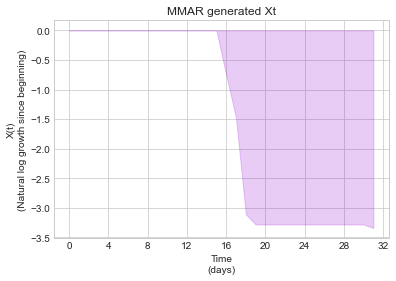

In [108]:
# --- MMAR returns's ---
simulated_xt_array = [0 for x in range(0, len(tradingtime))]

for i in range(0, len(tradingtime)):
    simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]

plt.title("MMAR generated Xt")
plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
plt.xlabel("Time\n(days)")
plt.ylabel('X(t)\n(Natural log growth since beginning)')
plt.grid(b=True)
plt.fill_between(np.arange(0, 2**K, 1) , simulated_xt_array, color="darkviolet", alpha=0.2)
plt.show()

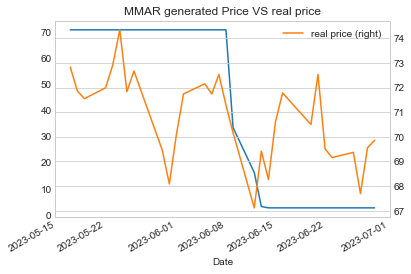

In [109]:
# --- PRICES ---
simulated_prices_array = prices_data_train.values[-1]*np.exp(simulated_xt_array[:len(prices_data_test)])

pd.Series(simulated_prices_array, index=prices_data_test.index).plot(label='simulated price')
prices_data_test.plot(label='real price', secondary_y=True)
plt.title("MMAR generated Price VS real price")
plt.legend()

#### Estmated the payoff by the averaging simulated prices

In [111]:
# parameters
S0 = prices_data_train.values[-1]  
strike_p = S0
r = 0.05
T = 1.0/12

In [112]:
call_payoff = np.exp(-r*T) * np.maximum(simulated_prices_array[-1] - strike_p, 0)  # This is for a call option
put_payoff = np.exp(-r*T) * np.maximum(strike_p - simulated_prices_array[-1], 0)  # This is for a call option
print("Call option price: ", call_payoff)
print("Put option price: ", put_payoff)

Call option price:  0.0
Put option price:  67.91326426463286


#### Estmated the payoff by the averaging payoffs

In [114]:
# simulate price paths and calculate payoffs
call_payoffs = []
put_payoffs = []
returns_list = []
for nb in tqdm(range(number_of_path)):
    new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    returns_list.append(new_fbm_simulation)
    
    # --- MMAR returns's ---
    simulated_xt_array = [0 for x in range(0, len(tradingtime))]
    for i in range(0, len(tradingtime)):
        simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
        
    # --- PRICES ---
    simulated_prices_array = S0*np.exp(simulated_xt_array[:len(prices_data_test)])
    
    call_payoff = np.maximum(simulated_prices_array[-1] - strike_p, 0)  # This is for a call option
    call_payoffs.append(call_payoff)
    
    put_payoff = np.maximum(strike_p - simulated_prices_array[-1], 0)  # This is for a call option
    put_payoffs.append(put_payoff)

# Calculate the option price as the average discounted payoff
call_option_price = np.exp(-r*T) * np.mean(call_payoffs)
put_option_price = np.exp(-r*T) * np.mean(put_payoffs)


print("Call option price: ", call_option_price)
print("Put option price: ", put_option_price)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.13it/s]

Call option price:  2.0441068333679076e+107
Put option price:  35.18163562590312


#### An initial look at The existing python package

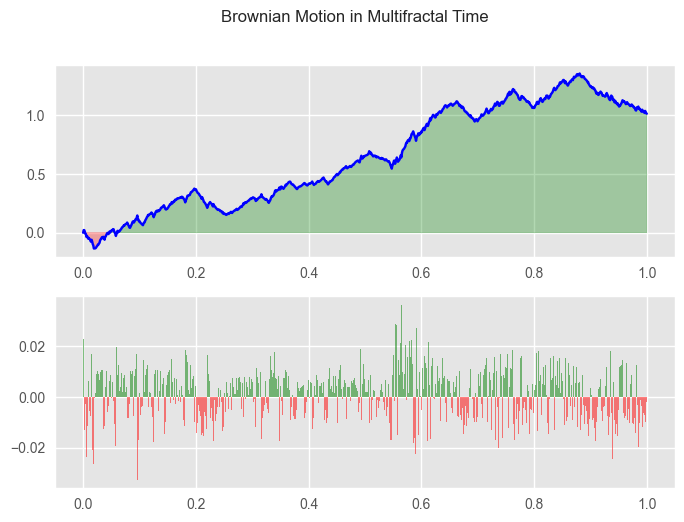

In [77]:
from fractalmarkets.mmar.brownian_motion_multifractal_time import BrownianMotionMultifractalTime
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from scipy import interpolate
import numpy as np

bmmt = BrownianMotionMultifractalTime(9, x=0.457, y=0.603, randomize_segments=True, randomize_time=True, M=[0.6, 0.4])
data = bmmt.simulate() # [ [x, y], ..., [x_n, y_n]]

f = interpolate.interp1d(data[:,0], data[:,1])

y = f(np.arange(0, 1, .001))
x = np.linspace(0, 1, len(y), endpoint=True)

y_diff = [b - a for a, b in zip(y[:-1], y[1:])]

fig, axs = plt.subplots(2)
fig.suptitle('Brownian Motion in Multifractal Time')

axs[0].plot(x, y, 'b-')
axs[1].bar(x[:-1],y_diff,align='edge',width=0.001,alpha=0.5)
bar_list=filter(lambda x: isinstance(x,matplotlib.patches.Rectangle),axs[1].get_children())
for bar,ret in zip(bar_list,y_diff):
    if ret >= 0:
        bar.set_facecolor('green')
    else:
        bar.set_facecolor('red')

z1 = np.array(y)
z2 = np.array([0] * len(y))

axs[0].fill_between(x, y, 0,
                where=(z1 >= z2),
                alpha=0.30, color='green', interpolate=True)

axs[0].fill_between(x, y, 0,
                where=(z1 < z2),
                alpha=0.30, color='red', interpolate=True)

plt.show()

In [83]:
test_multiplicative_cascade

<function __main__.test_multiplicative_cascade()>